In [8]:
library(tidyverse)
library(repr)
library(tidymodels)
library(lubridate)

## Group 42 Project - Tennis Data

### Introduction

The Association of Tennis Professionals (ATP) tennis circuit is for the best male tennis players in the world. The players are ranked based on how many points they accumulate when competing in ATP level tournaments. The better they perform in each tournament (i.e. the more rounds they win), the more points they accumulate, and the higher the players are ranked. Additionally, for each round that a player wins, they win a certain amount of prize money. As such, the player who wins the tournament receives the most amount of points and prize money. There are different levels of tournaments within the ATP circuit and the more prestigious ones, such as the Grand Slams, allow players to earn more points and prize money. However, they are more difficult to enter as you must have a certain rank to play. In the ATP ranking, points are updated on a weekly basis, and they are disregarded after 1 year. Therefore, whoever is number 1 has accumulated the most current points by winning the most. Therefore, it can also be assumed that they have accumulated the most prize money. 

In this project we are trying to predict what a player’s prize money would be based on current ranking, points accumulated, and their best rank. We are trying to see how much money a player would be expected to make if they were a certain rank. 

To do so, we are using the dataset: player_stats. The dataset contains information about the current top 500 tennis players in the ATP. The most pertinent information from the dataset for our project would be current ranking, best rank, prize money, and their age. Some columns and rows are very sparse, as much information is missing. Currently, the players are not ranked in order, but that will be changed. 


### Data Analysis 

In [6]:
#Demonstrate that the dataset can be read from the web into R
tennis_data <- read_csv("player_stats.csv")

New names:
• `` -> `...1`
Rows: 500 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (25): Age, Country, Plays, Wikipedia, Current Rank, Best Rank, Name, Bac...
dbl (13): ...1, Turned Pro, Seasons, Titles, Best Season, Retired, Masters, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [7]:
#Clean and wrangle your data into a tidy format
names(tennis_data)[names(tennis_data) == 'Prize Money'] <- 'prize_money'#renames Prize Money column to prize_money
tidy_tennis <- tennis_data |>
    select(Age:Plays,("Current Rank"):prize_money)|> #Removes columns with high proportions of NA 
    separate(col=Age,into=c("age","birth_date"),sep=" ")|> #Separates age and birth date into seperate columns
    separate(col=("Current Rank"),into=c("current_rank","points"),sep=" ")|> #Separates current rank and points into separate columns)
    separate(col=("Best Rank"),into=c("best_rank", "best_rank_date"),sep=" ")|> #Separates best rank and date of best rank into separate columns
    mutate(birth_date= gsub("[()]","",birth_date)) |> #Removes brackets
    mutate(points= gsub("[()]", "", points)) |> #Removes brackets
    mutate(best_rank_date=gsub("[()]","",best_rank_date))|> #Removes brackets
    mutate(birth_date=as_date(birth_date, format='%d-%m-%Y')) |> #Converts birth_date column to date objects
    mutate(best_rank_date=as_date(best_rank_date, format='%d-%m-%Y')) |> #Converts best_rank_date column to date objects
    mutate(age=as.numeric(age)) |> #Converts age column to numberic objects
    mutate(current_rank=as.numeric(current_rank)) |> #Converts current_rank column to numberic objects
    mutate(points=as.numeric(points)) |> #Converts points column to numberic objects
    mutate(best_rank=as.numeric(best_rank))|> #Converts best_rank column to numberic objects
    mutate(prize_money=gsub("[US$,]","",prize_money))|> #Removes some of the non-numeric aspects of prize_money data
    separate(col=prize_money,into=c("prize_money","x"),sep=". ") |> #removes the remaining non-numeric aspects of prize_money data
    select(age:prize_money) |> #removes unnecessary x column, which contained removed non-numeric aspects of prize-money data
    mutate(prize_money=as.numeric(prize_money))
tidy_tennis

Warning message:
“Expected 2 pieces. Additional pieces discarded in 20 rows [16, 96, 128, 142,
208, 212, 267, 274, 337, 363, 364, 381, 394, 414, 423, 435, 436, 461, 468,
497].”
Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 397 rows [2, 3, 4, 5, 6,
7, 8, 9, 10, 11, 12, 13, 14, 15, 18, 19, 20, 21, 22, 23, ...].”


age,birth_date,Country,Plays,current_rank,points,best_rank,best_rank_date,Name,Backhand,prize_money
<dbl>,<date>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<date>,<chr>,<chr>,<dbl>
26,1993-04-25,Brazil,Right-handed,378,97,363,2019-11-04,Oscar Jose Gutierrez,NA,NA
18,2001-12-22,United Kingdom,Left-handed,326,119,316,2019-10-14,Jack Draper,Two-handed,59040
32,1987-11-03,Slovakia,Right-handed,178,280,44,2013-01-14,Lukas Lacko,Two-handed,3261567
21,1998-05-29,"Korea, Republic of",Right-handed,236,199,130,2017-04-10,Duck Hee Lee,Two-handed,374093
27,1992-10-21,Australia,Right-handed,183,273,17,2016-01-11,Bernard Tomic,Two-handed,6091971
22,1997-02-11,Poland,Right-handed,31,1398,31,2020-01-20,Hubert Hurkacz,Two-handed,1517157
28,1991-11-18,United States,Right-handed,307,131,213,2016-10-31,Sekou Bangoura,Two-handed,278709
21,1998-05-12,"Taiwan, Province of China",Right-handed,232,205,229,2019-11-04,Tung Lin Wu,Two-handed,59123
25,1994-07-29,Uzbekistan,Right-handed,417,81,253,2017-07-17,Sanjar Fayziev,Two-handed,122734


Warning message:
“Removed 2 rows containing missing values (`geom_point()`).”


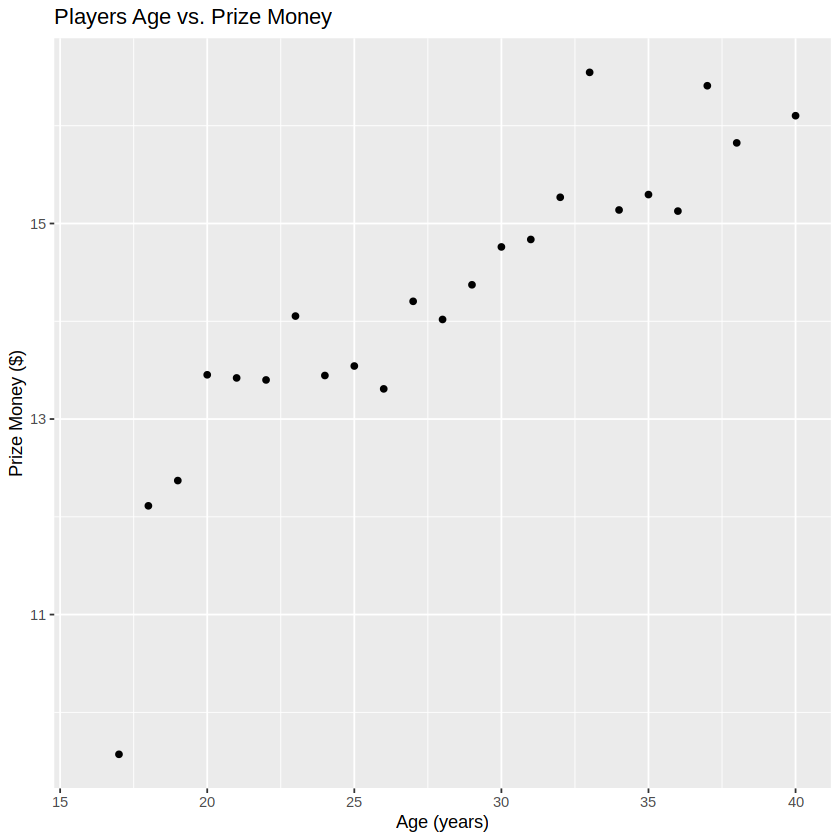

In [18]:
tennis_plot <- tidy_tennis |>
    group_by(age) |>
    summarise(prize_money = mean(prize_money, na.rm=TRUE)) |>
    ggplot(aes(x = age, y = log(prize_money))) + 
    geom_point() + 
    labs(x = "Age (years)", y = "Prize Money ($)") + 
    ggtitle("Players Age vs. Prize Money")

tennis_plot

In [42]:
?gsub

grep {base},R Documentation
pattern,"character string containing a regular expression (or character string for fixed = TRUE) to be matched in the given character vector. Coerced by as.character to a character string if possible. If a character vector of length 2 or more is supplied, the first element is used with a warning. Missing values are allowed except for regexpr, gregexpr and regexec."
"x, text","a character vector where matches are sought, or an object which can be coerced by as.character to a character vector. Long vectors are supported."
ignore.case,"if FALSE, the pattern matching is case sensitive and if TRUE, case is ignored during matching."
perl,logical. Should Perl-compatible regexps be used?
value,"if FALSE, a vector containing the (integer) indices of the matches determined by grep is returned, and if TRUE, a vector containing the matching elements themselves is returned."
fixed,"logical. If TRUE, pattern is a string to be matched as is. Overrides all conflicting arguments."
useBytes,logical. If TRUE the matching is done byte-by-byte rather than character-by-character. See ‘Details’.
invert,logical. If TRUE return indices or values for elements that do not match.
replacement,"a replacement for matched pattern in sub and gsub. Coerced to character if possible. For fixed = FALSE this can include backreferences ""\1"" to ""\9"" to parenthesized subexpressions of pattern. For perl = TRUE only, it can also contain ""\U"" or ""\L"" to convert the rest of the replacement to upper or lower case and ""\E"" to end case conversion. If a character vector of length 2 or more is supplied, the first element is used with a warning. If NA, all elements in the result corresponding to matches will be set to NA."


### Method

Using the dataset, we will be performing a regression analysis. This form of analysis was chosen because we are trying to predict a numerical value. We will be using the columns: age, birth_date, current_rank, points, best_rank, best_rank_date, and prize_money. All other columns will be disregarded when performing regression as they do not aid our predictions. All other columns are valuable information as they all play a part in how much prize money a player will receive in the future. Using regression analysis, we will create a hypothetical ATP tennis player and predict how much prize money they will earn based on their current statistics. 

To visualize the results, we will be creating multiple scatter plots that we can use to predict a hypothetical player’s current prize money. Each graph would visualize how a certain variable (age, birth_date, current_rank, points, best_rank, best_rank_date, or prize_money) affects prize money amount (in dollars, most likely scaled to accommodate for the large range). In doing so, we are able to see which variable has the largest influence on prize money. 


### Expected Outcomes and Significance

By performing regression analysis, we are expecting to discover which variables have the largest influence on prize money. We are hypothesizing that factors age and current rank will impact prize money the most. Specifically, the lower the age and the higher the rank, the more prize money the player is expected to receive. 

These findings could potentially allow players to calculate their expected financial trajectory. In doing so, it allows them to assess their current situation and decide whether continuing to be a tennis professional is a worthy investment. The data also allows players to set goals for themselves. Additionally, these findings are useful for investors as they are able to analyze which player has the most financial potential. Overall, this data allows multiple parties to see how they are able to maximize their financial income. 

Through this analysis, there are many future questions that can be proposed. For example, we could use these statistics to analyze how much money an ATP tennis player is expected to make from endorsements based on these factors. We could also use this data to predict at what age a tennis player will retire based on these factors. 